# Beat the Market with Yearly Stock Picks: A 38% Annual Return Strategy
1. Find out 3 years continuous uptrend in OEPS
2. Find out OEPS > 0 in 3 years 
3. Buy only when shorlisted stock are in uptrend, sell when break uptrend and price is below SMA20


In [1]:
import requests
import pandas as pd
import certifi
import json
from urllib.request import urlopen
from datetime import datetime
import time
import pandas_ta as ta
import numpy as np

In [2]:
# data = dataframe in pandas format to calculate sma
# ema_value = is an array to calcuate the lenth of ema 
# variable = variable used to calculate ema, it can be a "Close", or "Adj Close" in string format
def ema(data,ema_value,variable):
    # auto assign a variable name based on length of ema 
    variable_name = 'EMA'+ str(ema_value)
    # calculate ema 
    data[variable_name] = data[variable].ewm(span=ema_value, adjust=False).mean()
     # return ema variable calculated 
    return data[variable_name]

# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]

In [3]:

def get_jsonparsed_data(url):
    response = urlopen(url, cafile=certifi.where())
    data = response.read().decode("utf-8")
    return pd.DataFrame(json.loads(data))

In [4]:
def Get_Signal(data):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df_init.sort_values(by = 'date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    #df_init.dropna(subset=['SMA120'],inplace=True)
    #df_init.dropna(subset=['SMA120'],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    #df_init['signal'] = np.nan 
    # trigger a buy only if it is a up trend 
    #df_init.loc[(df['adjClose']>=df[variable_lower])&(df[variable_lower]>=df[variable_upper]) ,'Signal'] = 1
    
    # just triggered sell as close is less than variable triggered
    df_init.loc[(df_init['adjClose']<df_init['sma20']) ,'Signal'] = -1
    df_init.loc[((df_init['uptrend']==False) ) ,'Signal'] = -1
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['Signal'] = df_init['Signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.date == i,'Signal'] = 0 
        else:
            
    
            #print(prev)
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[(df_init.date == prev),'Signal'].values[0]==-1):
                df_init.loc[df_init.date == i,'Signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[(df_init.date == prev)  ,'Signal'].values[0]==1):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==2)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]!=-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 2

            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[(df_init.date == prev) ,'Signal'].values[0]==0)&(df_init.loc[(df_init.date == i) ,'Signal'].values[0]==-1) ):
                df_init.loc[df_init.date == i,'Signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init

In [5]:
import datetime
def backtest_strategy(df_init,capital):
    df_init= all_signal[['date','Price','Signal','Symbol']].copy()
    df_init.date =pd.to_datetime(df_init.date)
    df_init = df_init.sort_values(by=['date'])
    df_init.set_index('date',inplace=True)
    calendar = df_init.index.unique()
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=df_init.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)

    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)

    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]

    for date in calendar: 
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        stock_holding=[]
        for stock_check in df_init[(df_init.index==prev_date) & (df_init['units']>0)].Symbol.unique():
            # calculate total stock value of yesterday 
            tem_stock_holding =df_init.loc[(df_init.index==prev_date) & (df_init.Symbol ==stock_check), 'units'].values[0]*df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check),'Price'].values[0]
            stock_holding.append(tem_stock_holding)

        stock_holding = sum(stock_holding)
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()
        stock_pick = df_init.loc[date].Symbol.unique()
        print(date)
        print(port_value)
        stock_to_hold = len(df_init[((df_init['Signal']==1)|(df_init['Signal']==2))&(df_init.index==date)].Symbol.unique())
        if stock_to_hold >0:
            for stock_check in df_init[(df_init.index==date)].Symbol.unique():
                if ((df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Signal'].values[0] == 0)|(df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Signal'].values[0] == -1)):          
                    df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'units'] = 0
                    df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'cash'] =0   

                elif df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Signal'].values[0] == 1:

                    unit_buy = int((port_value/stock_to_hold)/df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Price'].values[0])
                    df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'units'] = unit_buy
                    df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'cash'] = port_value/stock_to_hold - unit_buy*df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'Price'].values[0]   

                elif df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Signal'].values[0] == 2:        
                    unit_buy = int((port_value/stock_to_hold)/df_init.loc[(df_init.index==date) & (df_init.Symbol ==stock_check), 'Price'].values[0])
                    df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'units'] = unit_buy
                    df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'cash'] = port_value/stock_to_hold - unit_buy*df_init.loc[(df_init.index==date)& (df_init.Symbol ==stock_check), 'Price'].values[0]   
                   
        else:
            total_stock = len(df_init[(df_init.index==date)].Symbol.unique())
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] = port_value/total_stock
    df_init[df_init.index!=df_init.index.min()]
    return (df_init)

In [6]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [9]:
api = 'Key In your FMP API'

In [12]:
from datetime import date
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker_all = df['Symbol'].values
all_eps= pd.DataFrame()
Yearly_eps = pd.DataFrame()
for ticker_Select in ticker_all:
    print(ticker_Select)
    ticker=ticker_Select
    EPS_link = 'https://financialmodelingprep.com/api/v4/owner_earnings?symbol='+ticker+'&apikey='+api
    # daily_stock_temp = api_reading(daily_stock_link )
    eps = get_jsonparsed_data(EPS_link)
    if eps.shape[0]>0:
        eps = eps.sort_values(by='date')
        eps['EPS_Sum_4Quarters'] = eps['ownersEarningsPerShare'].rolling(window=4).sum()
        eps['QuarterlyEPSIncrease'] = eps['EPS_Sum_4Quarters'].pct_change() * 100
        eps['QuarterlyEPSIncrease'] = (   eps['EPS_Sum_4Quarters'] -  eps['EPS_Sum_4Quarters'].shift(1))/abs( eps['EPS_Sum_4Quarters'].shift(1))*100
        eps['ContinuousIncreaseQuarter'] = eps['QuarterlyEPSIncrease'] > 5
        eps['ContinuousIncrease_lastQuarter'] = eps['ContinuousIncreaseQuarter'].shift(1)
        eps['ContinuousIncrease_last2Quarter'] = eps['ContinuousIncreaseQuarter'].shift(2)
        # Create a new column 'Year' containing the year extracted from the 'Date' column
        eps['Year'] = pd.to_datetime(eps['date']).dt.year
        YearEPS = eps.groupby(['Year'])['ownersEarningsPerShare'].sum().reset_index().rename(columns = {'ownersEarningsPerShare':'YearlyEPS'})
        YearEPS['EPS_GrowthYearly'] =(  YearEPS['YearlyEPS'] - YearEPS['YearlyEPS'].shift(1))/abs(YearEPS['YearlyEPS'].shift(1))*100
        # Add a new column 'ContinuousIncrease' to indicate if the EPS is continuously increasing
        YearEPS['ContinuousIncreaseyearly'] = YearEPS['EPS_GrowthYearly'] > 5
        YearEPS['ContinuousIncrease_lastyear'] = YearEPS['ContinuousIncreaseyearly'].shift(1)
        YearEPS['ContinuousIncrease_last2year'] = YearEPS['ContinuousIncreaseyearly'].shift(2)
        YearEPS['YearlyEPS_lastyear'] = YearEPS['YearlyEPS'].shift(1)
        YearEPS['YearlyEPS_last2year'] = YearEPS['YearlyEPS'].shift(2)
        # Create a DataFrame with all possible date and symbol combinations
        date_range = pd.date_range(start=eps['date'].min(), end=date.today(), freq='D')
        all_combinations = pd.MultiIndex.from_product([date_range], names=['date']).to_frame(index=False)
        all_combinations['date'] = pd.to_datetime(all_combinations['date']).dt.strftime("%Y-%m-%d")
        eps= pd.merge(all_combinations, eps, on=[ 'date'], how='left')
        # Fill missing values with the previous price target
        eps['EPS_Sum_4Quarters'] = eps['EPS_Sum_4Quarters'].fillna(method='ffill')
        #eps['YearlyEPS'] = eps['YearlyEPS'].fillna(method='ffill')
        #eps['EPS_GrowthYearly'] = eps['EPS_GrowthYearly'].fillna(method='ffill')
        eps['Year'] = eps['Year'].fillna(method='ffill')
        eps['ownersEarningsPerShare'] = eps['ownersEarningsPerShare'].fillna(method='ffill')
        eps['EPS_Sum_4Quarters'] = eps['EPS_Sum_4Quarters'].fillna(method='ffill')
        eps['QuarterlyEPSIncrease'] = eps['QuarterlyEPSIncrease'].fillna(method='ffill')
        eps['ContinuousIncreaseQuarter'] = eps['ContinuousIncreaseQuarter'].fillna(method='ffill')
        eps['ContinuousIncrease_last2Quarter'] = eps['ContinuousIncrease_last2Quarter'].fillna(method='ffill')
        eps['ContinuousIncrease_lastQuarter'] = eps['ContinuousIncrease_lastQuarter'].fillna(method='ffill')
        eps =pd.merge(eps,YearEPS,on = 'Year',how='left')
        eps['symbol'] = ticker
        all_eps= pd.concat([eps,all_eps])
        YearEPS['symbol'] = ticker
        Yearly_eps = pd.concat([Yearly_eps,YearEPS])

MMM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ABT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ABBV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ACN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ADBE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AFL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


A


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


APD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ABNB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AKAM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ARE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALLE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LNT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GOOGL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GOOG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMZN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMCR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AEE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AEP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AXP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AIG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AWK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AME
AMGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


APH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ADI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ANSS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


APA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AAPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AMAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


APTV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ACGL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ADM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ANET


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AJG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AIZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


T


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ATO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ADSK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ADP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AZO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AVB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AVY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AXON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BKR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BALL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BBWI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BAX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BDX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BRK.B


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BBY
BIO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TECH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BIIB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BLK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BKNG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BWA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BXP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BMY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


AVGO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BRO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BF.B


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BG
CDNS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CZR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CPT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CPB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


COF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CAH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KMX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CARR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CTLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CBOE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CBRE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CDW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


COR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CNC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CNP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CDAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CHRW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CRL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SCHW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CHTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CVX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CMG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CHD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CINF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CTAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CSCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


C


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CFG
CLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CME


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CMS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CTSH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CMCSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CMA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CAG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


COP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ED


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


STZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CEG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


COO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CPRT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GLW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CTVA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CSGP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


COST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CTRA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CMI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CVS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DHR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DRI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DVA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


XRAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DVN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DXCM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FANG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DLR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DFS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DLTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


D


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DPZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DOV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DHI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DTE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DUK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ETN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EBAY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ECL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EIX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ELV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LLY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EMR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ENPH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ETR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EOG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EPAM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EQT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EFX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EQIX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EQR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ESS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ETSY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EVRG
ES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EXC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EXPE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EXPD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


EXR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


XOM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FFIV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FDS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FICO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FAST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FRT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FDX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FITB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FSLR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


F


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FTNT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FTV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FOXA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FOX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


BEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


FCX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GRMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GEHC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GNRC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GPC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GILD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GPN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HIG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HCA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PEAK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HSIC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HSY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HES


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HPE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HLT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HOLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HRL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HWM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HPQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HUBB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HUM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HBAN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


HII


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IBM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IEX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IDXX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ITW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ILMN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


INCY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PODD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


INTC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ICE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IFF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


INTU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ISRG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IVZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


INVH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IQV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


IRM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JBHT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JKHY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


J


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JNJ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JPM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


JNPR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


K


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KVUE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KDP
KEY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KEYS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KIM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KMI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KLAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KHC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


KR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LHX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LRCX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LVS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LDOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LEN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LIN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LYV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LKQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


L


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LULU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LYB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MTB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MRO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MPC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MKTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MAR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MLM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MAS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MTCH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MKC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MCD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MCK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MDT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MRK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


META


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MET


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MTD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MGM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MCHP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MSFT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MAA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MRNA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MHK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MOH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TAP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MDLZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MPWR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MNST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MOS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MSI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


MSCI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NDAQ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NTAP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NFLX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NEM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NWSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NWS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NEE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NKE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NDSN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NSC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NTRS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NOC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NCLH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NRG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NUE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NVDA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NVR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NXPI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ORLY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


OXY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ODFL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


OMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ON


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


OKE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ORCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


OTIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PCAR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PKG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PANW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PARA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PAYX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PAYC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PYPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PNR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PEP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PFE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PCG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PSX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PNW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PXD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PNC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


POOL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PPL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PFG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PGR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PLD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PRU


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PEG
PTC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PSA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PHM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


QRVO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


PWR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


QCOM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DGX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RJF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


O


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


REG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


REGN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RSG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RMD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RVTY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RHI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ROK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ROL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ROP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ROST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


RCL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SPGI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


CRM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SBAC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SLB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


STX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SEE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SRE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


NOW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SHW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SPG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SWKS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SJM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SNA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SEDG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


LUV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SWK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SBUX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


STT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


STLD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


STE


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SYK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SYF


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


SNPS
SYY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TMUS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TROW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TTWO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TPR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TRGP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TGT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TEL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TDY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TFX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TER


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TSLA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TXN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TXT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TMO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TJX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TSCO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TDG


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TRV


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TRMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TYL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


TSN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


USB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UDR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ULTA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UNP


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UAL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UPS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


URI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UNH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


UHS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VLO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VTR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VLTO


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VRSN
VRSK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VZ


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VRTX


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VTRS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VICI


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


V


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


VMC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WRB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WAB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WBA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WMT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


DIS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WBD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WAT


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WEC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WFC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WELL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WST


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WDC


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WRK


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WY


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WHR


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WMB


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WTW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


GWW


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


WYNN


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


XEL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


XYL


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


YUM


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ZBRA


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ZBH


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ZION


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ZTS


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [14]:
selected_stock = Yearly_eps.copy()
selected_stock = Yearly_eps[(Yearly_eps['ContinuousIncreaseyearly']==True ) & (Yearly_eps['ContinuousIncrease_lastyear']==True )& (Yearly_eps['ContinuousIncrease_last2year']==True )& (Yearly_eps['symbol']!='GOOG' )]
selected_stock = selected_stock[(selected_stock['YearlyEPS_last2year']>0)& (selected_stock['YearlyEPS_lastyear']>0)]

# calculate yearly EPS and buy only the one highest growth
selected_stock = selected_stock[selected_stock['YearlyEPS']>0]
selected_stock['EPS_Rank'] = selected_stock.groupby([ 'Year'])['EPS_GrowthYearly'].rank(ascending=False)
Not_selected =Yearly_eps[(Yearly_eps['ContinuousIncreaseyearly']==False )|(Yearly_eps['ContinuousIncrease_lastyear']==False )|(Yearly_eps['ContinuousIncrease_last2year']==False )|(Yearly_eps['YearlyEPS']<0)|(Yearly_eps['YearlyEPS_last2year']<0)|(Yearly_eps['YearlyEPS_lastyear']<0)]
Not_selected['EPS_Rank'] = 999 
selected_stock =pd.concat([selected_stock,Not_selected])
selected_stock['InvestedYear'] = selected_stock[ 'Year']+1
selected_stock.loc[selected_stock['EPS_Rank']<=5,'Signal']=1
selected_stock.loc[selected_stock['EPS_Rank']>5,'Signal']=0
selected_stock.reset_index(inplace=True)
selected_stock['LastYearEPS_Rank'] = selected_stock.sort_values(by = 'Year').groupby(['symbol'])['EPS_Rank'].shift(1)
# define apr as cut off
selected_stock['InvestedDateFrom'] = selected_stock['InvestedYear'].astype(str).str[:4]  +'-04-01'
selected_stock['InvestedDateTo'] = (selected_stock['InvestedYear']+1).astype(str).str[:4]  +'-04-01'
#all_raw = pd.merge(all_raw,YearlyEPS[['symbol', 'InvestedYear','Signal']],left_on = ['symbol','year'], right_on = ['symbol', 'InvestedYear'])

C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/2325089211.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Not_selected['EPS_Rank'] = 999


In [20]:
selected_stock.to_csv('test2.csv')

In [15]:
import pandas_ta as ta
ticker_all =selected_stock[(selected_stock['Signal']==1)&(selected_stock['Year']>2017)].symbol.unique()
all_daily_stock = pd.DataFrame()
for ticker_Select in ticker_all:
    print(ticker_Select)
    #ticker = stock_extract
    daily_stock_link = 'https://financialmodelingprep.com/api/v3/historical-price-full/'+ticker_Select+'?apikey='+api
    daily_stock = get_jsonparsed_data(daily_stock_link )
    daily_stock = pd.json_normalize(daily_stock['historical'])
    daily_stock = daily_stock.sort_values(by=['date'])
    daily_stock['Symbol'] = ticker_Select
    daily_stock['ema20'] = ema(daily_stock,20,'adjClose')
    daily_stock['sma20'] = sma(daily_stock,20,'adjClose')
    daily_stock['sma60'] = sma(daily_stock,60,'adjClose')
    daily_stock['sma120'] = sma(daily_stock,120,'adjClose')
    all_daily_stock = pd.concat([all_daily_stock,daily_stock])
    

AMD


C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


ALGN
GOOGL
AIZ
AVGO
CBOE
DE
DXCM
DG
D
ENPH
ETSY
EVRG
EXPD
FDS
IT
IQV
KHC
LIN
META
MOS
NVR
PNW
PHM
SNPS
TSLA
TSCO
ULTA
V
DIS


In [29]:
all_raw = pd.merge(all_daily_stock,all_eps, left_on =['Symbol','date'], right_on = ['symbol','date'],how='left')
#all_raw['uptrend'] = all_raw['adjClose']>=all_raw['SMA20']
all_raw['uptrend'] = all_raw['sma20']>=all_raw['SMA60']
all_raw['year'] = pd.to_datetime(all_raw['date']).dt.year
all_raw = pd.merge(all_raw,selected_stock[['symbol', 'InvestedYear','Signal','EPS_Rank','LastYearEPS_Rank','InvestedDateFrom','InvestedDateTo']],left_on = ['symbol','year'], right_on = ['symbol', 'InvestedYear'],how='left')
all_raw.loc[(all_raw.date>=all_raw.InvestedDateFrom) &(all_raw.date<all_raw.InvestedDateTo) & (all_raw.EPS_Rank<=5),'Signal']=1
all_raw.loc[(all_raw.date<all_raw.InvestedDateFrom) & (all_raw.EPS_Rank<=5),'Signal']=0
all_raw.loc[(all_raw.date<all_raw.InvestedDateFrom) &  (all_raw.LastYearEPS_Rank<=5),'Signal']=1

In [30]:
all_signal = pd.DataFrame()
for stock_pick in all_raw.Symbol.unique():
    
    temp_data = all_raw[all_raw['symbol']==stock_pick]
    temp_data = temp_data.sort_values(by=['date'])
    temp_data = Get_Signal(temp_data)
    all_signal = pd.concat([all_signal,temp_data])

# Open price backtest

In [31]:
all_signal['Price'] = all_signal['open'] 

In [32]:
backtest_result = backtest_strategy(df_init = all_signal,capital=1000)
backtest_result['Total_value'] = backtest_result['units']*backtest_result['Price']+backtest_result['cash']    

2018-12-17 00:00:00
1000.0
2018-12-18 00:00:00
1000.0000000000002
2018-12-19 00:00:00
1000.0000000000005
2018-12-20 00:00:00
1000.0000000000007
2018-12-21 00:00:00
1000.0000000000008
2018-12-24 00:00:00
1000.0000000000008
2018-12-26 00:00:00
1000.0000000000008
2018-12-27 00:00:00
1000.0000000000008
2018-12-28 00:00:00
1000.0000000000008
2018-12-31 00:00:00
1000.0000000000008
2019-01-02 00:00:00
1000.0000000000008
2019-01-03 00:00:00
1000.0000000000008
2019-01-04 00:00:00
1000.0000000000008
2019-01-07 00:00:00
1000.0000000000008
2019-01-08 00:00:00
1000.0000000000008
2019-01-09 00:00:00
1000.0000000000008
2019-01-10 00:00:00
1000.0000000000008
2019-01-11 00:00:00
1000.0000000000008
2019-01-14 00:00:00
1000.0000000000008
2019-01-15 00:00:00
1000.0000000000008
2019-01-16 00:00:00
1000.0000000000008
2019-01-17 00:00:00
1000.0000000000008
2019-01-18 00:00:00
1000.0000000000008
2019-01-22 00:00:00
1000.0000000000008
2019-01-23 00:00:00
1000.0000000000008
2019-01-24 00:00:00
1000.000000000000

2019-10-23 00:00:00
1017.3200000000023
2019-10-24 00:00:00
1077.4800000000023
2019-10-25 00:00:00
1079.5600000000022
2019-10-28 00:00:00
1114.8200000000024
2019-10-29 00:00:00
1092.0600000000024
2019-10-30 00:00:00
1086.8100000000027
2019-10-31 00:00:00
1089.9400000000028
2019-11-01 00:00:00
1096.9800000000027
2019-11-04 00:00:00
1101.5900000000029
2019-11-05 00:00:00
1095.3900000000028
2019-11-06 00:00:00
1090.720000000003
2019-11-07 00:00:00
1106.940000000003
2019-11-08 00:00:00
1106.930000000003
2019-11-11 00:00:00
1116.480000000003
2019-11-12 00:00:00
1128.8400000000029
2019-11-13 00:00:00
1127.490000000003
2019-11-14 00:00:00
1108.260000000003
2019-11-15 00:00:00
1122.070000000003
2019-11-18 00:00:00
1118.520000000003
2019-11-19 00:00:00
1114.7600000000027
2019-11-20 00:00:00
1140.6100000000029
2019-11-21 00:00:00
1134.3400000000029
2019-11-22 00:00:00
1104.5400000000027
2019-11-25 00:00:00
1110.7500000000027
2019-11-26 00:00:00
1116.0300000000027
2019-11-27 00:00:00
1097.23000000

2020-08-25 00:00:00
2024.9200000000044
2020-08-26 00:00:00
2003.6800000000044
2020-08-27 00:00:00
2013.7200000000043
2020-08-28 00:00:00
2032.1300000000047
2020-08-31 00:00:00
2012.100000000005
2020-09-01 00:00:00
1992.870000000005
2020-09-02 00:00:00
2045.1600000000049
2020-09-03 00:00:00
2100.390000000005
2020-09-04 00:00:00
2052.660000000005
2020-09-08 00:00:00
1987.970000000005
2020-09-09 00:00:00
2048.4500000000053
2020-09-10 00:00:00
2132.3900000000053
2020-09-11 00:00:00
2133.380000000005
2020-09-14 00:00:00
2112.440000000005
2020-09-15 00:00:00
2136.1200000000053
2020-09-16 00:00:00
2162.8200000000056
2020-09-17 00:00:00
2128.3200000000056
2020-09-18 00:00:00
2119.580000000006
2020-09-21 00:00:00
2056.1700000000055
2020-09-22 00:00:00
2127.9900000000052
2020-09-23 00:00:00
2099.6700000000055
2020-09-24 00:00:00
2027.2800000000052
2020-09-25 00:00:00
2002.9700000000055
2020-09-28 00:00:00
2002.9700000000057
2020-09-29 00:00:00
1996.7900000000056
2020-09-30 00:00:00
2002.21000000

2021-07-01 00:00:00
2767.88240000001
2021-07-02 00:00:00
2787.0224000000103
2021-07-06 00:00:00
2750.33240000001
2021-07-07 00:00:00
2752.0524000000096
2021-07-08 00:00:00
2746.32240000001
2021-07-09 00:00:00
2739.96240000001
2021-07-12 00:00:00
2739.78240000001
2021-07-13 00:00:00
2723.3124000000103
2021-07-14 00:00:00
2699.9424000000104
2021-07-15 00:00:00
2654.072400000011
2021-07-16 00:00:00
2668.812400000011
2021-07-19 00:00:00
2658.3624000000113
2021-07-20 00:00:00
2688.2824000000114
2021-07-21 00:00:00
2704.452400000011
2021-07-22 00:00:00
2716.362400000011
2021-07-23 00:00:00
2734.1724000000104
2021-07-26 00:00:00
2787.5524000000105
2021-07-27 00:00:00
2776.4024000000104
2021-07-28 00:00:00
2739.94240000001
2021-07-29 00:00:00
2761.2624000000105
2021-07-30 00:00:00
2698.3924000000106
2021-08-02 00:00:00
2668.7624000000105
2021-08-03 00:00:00
2679.1924000000104
2021-08-04 00:00:00
2718.66240000001
2021-08-05 00:00:00
2734.4124000000097
2021-08-06 00:00:00
2750.3334000000095
2021

2783.3060000000037
2022-05-05 00:00:00
2823.6060000000034
2022-05-06 00:00:00
2831.4060000000036
2022-05-09 00:00:00
2854.8060000000037
2022-05-10 00:00:00
2910.0560000000037
2022-05-11 00:00:00
2844.4060000000036
2022-05-12 00:00:00
2854.1560000000036
2022-05-13 00:00:00
2826.2060000000038
2022-05-16 00:00:00
2914.606000000004
2022-05-17 00:00:00
2889.9060000000036
2022-05-18 00:00:00
2821.6560000000036
2022-05-19 00:00:00
2821.656000000004
2022-05-20 00:00:00
2821.656000000005
2022-05-23 00:00:00
2821.6560000000054
2022-05-24 00:00:00
2821.656000000006
2022-05-25 00:00:00
2821.6560000000063
2022-05-26 00:00:00
2821.6560000000063
2022-05-27 00:00:00
2821.6560000000063
2022-05-31 00:00:00
2821.6560000000063
2022-06-01 00:00:00
2821.6560000000063
2022-06-02 00:00:00
2821.6560000000063
2022-06-03 00:00:00
2821.6560000000063
2022-06-06 00:00:00
2821.6560000000063
2022-06-07 00:00:00
2821.6560000000063
2022-06-08 00:00:00
2821.6560000000063
2022-06-09 00:00:00
2821.6560000000063
2022-06-10

2023-03-14 00:00:00
3283.276
2023-03-15 00:00:00
3385.1359999999995
2023-03-16 00:00:00
3483.666
2023-03-17 00:00:00
3633.9260000000004
2023-03-20 00:00:00
3608.7260000000006
2023-03-21 00:00:00
3663.806000000001
2023-03-22 00:00:00
3633.206000000001
2023-03-23 00:00:00
3715.126000000001
2023-03-24 00:00:00
3717.9560000000006
2023-03-27 00:00:00
3697.746000000001
2023-03-28 00:00:00
3630.8060000000005
2023-03-29 00:00:00
3641.106
2023-03-30 00:00:00
3648.2960000000003
2023-03-31 00:00:00
3652.3559999999998
2023-04-03 00:00:00
3677.6960000000004
2023-04-04 00:00:00
3725.902
2023-04-05 00:00:00
3722.126
2023-04-06 00:00:00
3702.7960000000003
2023-04-10 00:00:00
3726.4060000000004
2023-04-11 00:00:00
3733.5260000000003
2023-04-12 00:00:00
3726.9160000000006
2023-04-13 00:00:00
3714.986000000001
2023-04-14 00:00:00
3726.266000000001
2023-04-17 00:00:00
3716.2860000000005
2023-04-18 00:00:00
3735.696000000001
2023-04-19 00:00:00
3686.5460000000007
2023-04-20 00:00:00
3700.696000000001
2023-

In [131]:
backtest_result.to_csv('backtest.csv')

In [33]:
summary_backtest_result = backtest_result[backtest_result.index>='2019-01-01'].reset_index().groupby(['index'])['Total_value'].sum().reset_index()

summary_backtest_result = summary_backtest_result.rename(columns = {'index':'date'})

In [34]:
# get summarize of total portfolio value, return by date, benchmark_index
summary_backtest_result['Return_without_trailing'] = summary_backtest_result['Total_value']/summary_backtest_result['Total_value'].iloc[0] *100
summary_backtest_result['Return_trailing_12m'] = summary_backtest_result['Total_value']/summary_backtest_result['Total_value'].shift(252)*100
summary_backtest_result.set_index('date',inplace=True)

In [25]:
QQQ_LINK = 'https://financialmodelingprep.com/api/v3/historical-price-full/'+'QQQ'+'?apikey='+api
QQQ_stock = get_jsonparsed_data(QQQ_LINK)
QQQ_stock = pd.json_normalize(QQQ_stock['historical'])
QQQ_stock = QQQ_stock[['date','adjClose']]
QQQ_stock['date'] = pd.to_datetime(QQQ_stock['date'])

C:\Users\CHIN\AppData\Local\Temp/ipykernel_4828/1728708311.py:2: DeprecationWarning: cafile, capath and cadefault are deprecated, use a custom context instead.
  response = urlopen(url, cafile=certifi.where())


In [26]:
QQQ_stock.sort_values('date',inplace=True)
QQQ_stock = QQQ_stock[QQQ_stock['date']>='2019-01-01']
QQQ_stock['QQQ-Return_without_trailing'] = QQQ_stock['adjClose']/QQQ_stock['adjClose'].iloc[0] *100
QQQ_stock['QQQ-Return_trailing_12m'] = QQQ_stock['adjClose']/QQQ_stock['adjClose'].shift(252)*100
QQQ_stock.set_index('date',inplace=True)

In [35]:
summary_backtest_result['QQQ-Return_without_trailing'] = QQQ_stock['QQQ-Return_without_trailing']
summary_backtest_result['QQQ-Return_trailing_12m'] = QQQ_stock['QQQ-Return_trailing_12m']


Annualized_return of Owners Earning Per Share strategy(Open Price): 39.9770705596185
MDD of Owners Earning Per Share strategy(Open Price): -21.502782611692016
Annualized_return of QQQ without trailing: 33.64806198910213
MDD of QQQ without trailing: -35.117107176889505


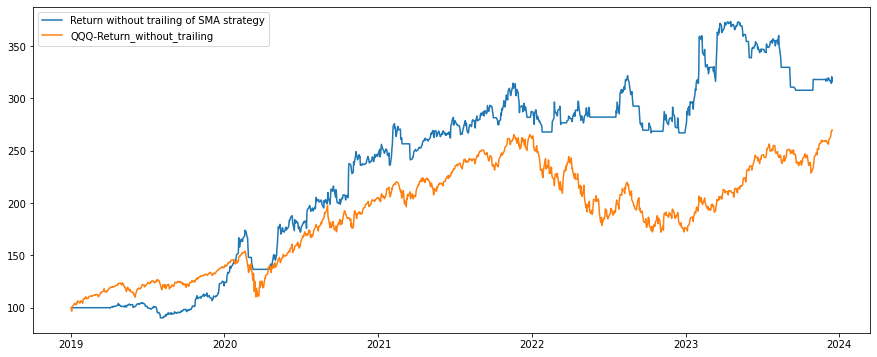

In [36]:
import matplotlib.pyplot as plt
# plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
plt.rcParams["figure.figsize"] = (15,6)
plt.plot(summary_backtest_result.Return_without_trailing, label='Return without trailing of SMA strategy')
plt.plot(summary_backtest_result['QQQ-Return_without_trailing'], label='QQQ-Return_without_trailing')
plt.legend()
print('Annualized_return of Owners Earning Per Share strategy(Open Price):',annualized (summary_backtest_result,'Return_without_trailing'))
print('MDD of Owners Earning Per Share strategy(Open Price):', MDD(summary_backtest_result,'Return_without_trailing'))

print('Annualized_return of QQQ without trailing:',annualized (summary_backtest_result,'QQQ-Return_without_trailing'))
print('MDD of QQQ without trailing:', MDD(summary_backtest_result,'QQQ-Return_without_trailing'))